In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
import nltk
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier



In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
class DataLoader:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, encoding='latin1')
    
    def preprocess(self):
        self.df.rename(columns={'tweet_text':'tweet', 'emotion_in_tweet_is_directed_at':'brand_product', 
                                'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'}, inplace=True)
        dict_sent = {'No emotion toward brand or product':"No emotion", 
                     'Positive emotion':'Positive',
                     'Negative emotion':'Negative',
                     "I can't tell": 'Invalid'}
        self.df['sentiment'] = self.df['sentiment'].map(dict_sent)
        self.df['tweet'].dropna(inplace=True)
        self.df.drop_duplicates(inplace=True)
        self.df.drop(index=self.df[self.df['tweet'].isna()].index, inplace= True)
        self.fill_missing_brand_product(np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android']))
        self.df.dropna(inplace=True)
        return self.df
    
    def fill_missing_brand_product(self, categories):
        for i, row in self.df.iterrows():
            if pd.isnull(row['brand_product']):
                for category in np.concatenate((categories, np.char.lower(categories))):
                    if category in row['tweet']:
                        self.df.loc[i, 'brand_product'] = category
                        break



In [4]:
data_loader = DataLoader('tweets.csv')
df = data_loader.preprocess()
df.head()

,tweet,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [5]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def preprocess_text(self):
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        def clean_text(text):
            text = re.sub(r'http\S+', '', text)  # Remove URLs
            text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
            text = text.lower()  # Convert to lowercase
            text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
            return text

        self.df['cleaned_tweet'] = self.df['tweet'].apply(clean_text)
        self.df['user_name'] = self.df['cleaned_tweet'].apply(lambda x: x.split()[0] if x else '')
        self.df['cleaned_tweet'] = self.df['cleaned_tweet'].apply(lambda x: ' '.join(x.split()[1:]) if x else '')
        return self.df

    def show_distribution(self):
        brand_counts = self.df['brand_product'].value_counts().sort_values(ascending=True)
        colors = ['skyblue' if brand.lower() in ['ipad', 'apple', 'ipad or iphone app', 'iphone', 'other apple product or service'] 
                  else 'limegreen' for brand in brand_counts.index]

        plt.figure(figsize=(10, 6))
        plt.barh(brand_counts.index, brand_counts.values, color=colors)
        plt.xlabel('Brand-Product')
        plt.ylabel('Count')
        plt.title('Distribution of Brand-Product')
        plt.xticks(rotation=60) 
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.countplot(data=self.df, x='sentiment', hue='brand_product', palette='Set2')
        plt.title('Sentiment Counts by Brand')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.legend(title='Brand')
        plt.show()



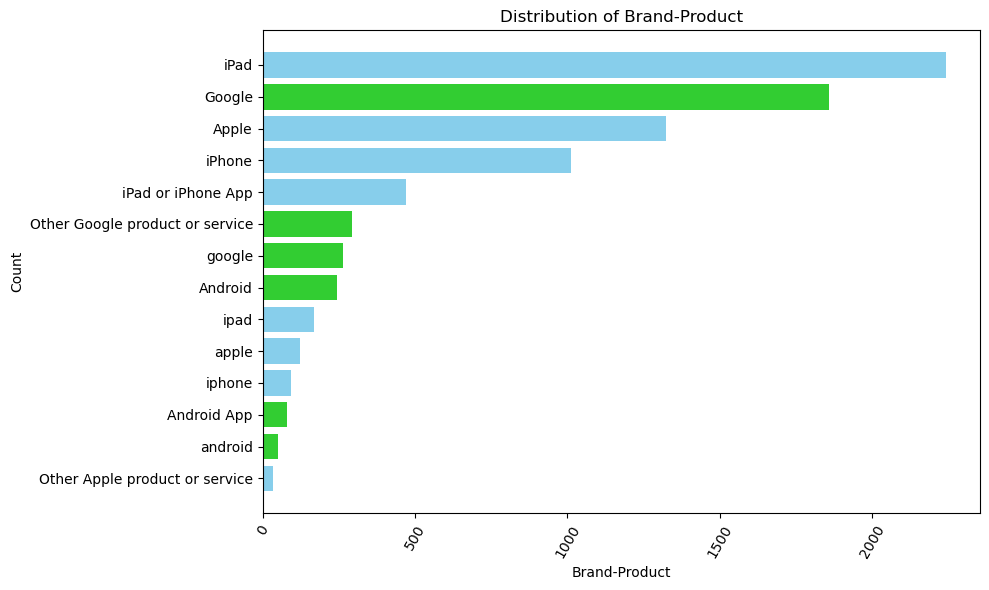

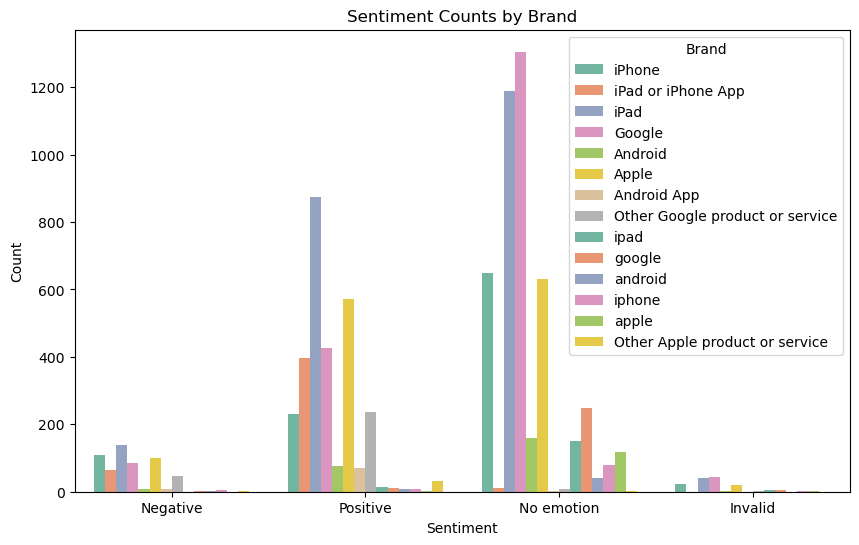

In [6]:
data_preprocessor = DataPreprocessor(df)
df = data_preprocessor.preprocess_text()
data_preprocessor.show_distribution()

In [7]:
class TextVectorizer:
    def __init__(self, df):
        self.df = df

    def vectorize_text(self):
        self.vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
        self.X = self.vectorizer.fit_transform(self.df['cleaned_tweet'])
        self.y = self.df['sentiment']
        return self.X, self.y

    def show_word_distribution(self):
        word_freq = self.vectorizer.get_feature_names_out()
        sum_words = self.X.sum(axis=0)
        word_freq = [(word, sum_words[0, idx]) for word, idx in self.vectorizer.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

        words = [wf[0] for wf in word_freq[:20]]
        counts = [wf[1] for wf in word_freq[:20]]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=counts, y=words)
        plt.title('Top 20 Words by Frequency')
        plt.show()

    def show_wordcloud(self):
        all_tweets_text = ' '.join(self.df['cleaned_tweet'])
        wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=40, scale=3, random_state=42)
        wordcloud.generate(all_tweets_text)

        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Cleaned Tweets')
        plt.show()

C:\Users\jack\Documents\Flatiron\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


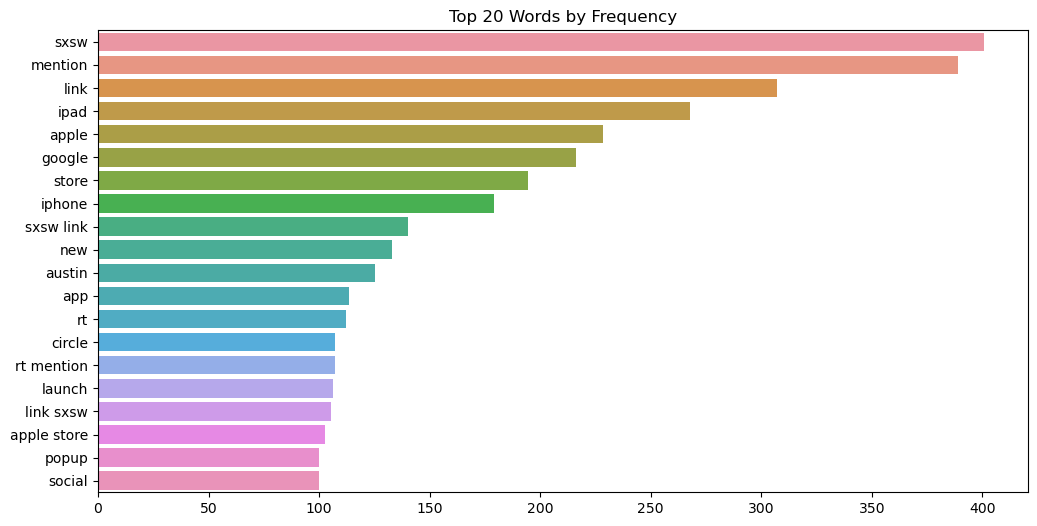

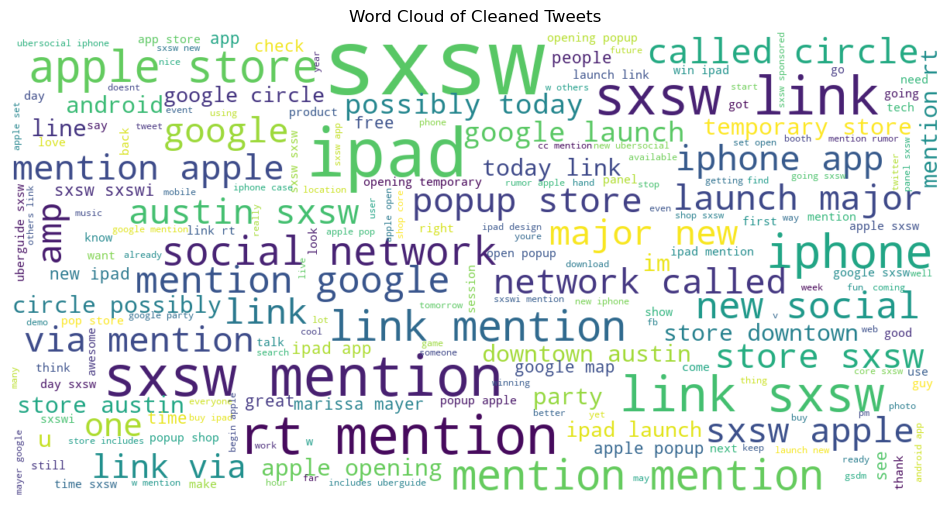

In [8]:
text_vectorizer = TextVectorizer(df)
X, y = text_vectorizer.vectorize_text()
text_vectorizer.show_word_distribution()
text_vectorizer.show_wordcloud()

In [9]:
class ModelTrainer:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def train_naive_bayes(self):
        nb_model = MultinomialNB()
        nb_model.fit(self.X_train, self.y_train)
        return nb_model

    def train_svc(self):
        svc_model = SVC(probability=True)
        param_grid = {'C': [0.1, 1, 10]}
        grid_search = GridSearchCV(svc_model, param_grid, cv=3)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_estimator_

    def train_random_forest(self):
        rf_model = RandomForestClassifier()
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
        grid_search = GridSearchCV(rf_model, param_grid, cv=3)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_estimator_

    def train_decision_tree(self):
        dt_model = DecisionTreeClassifier()
        param_grid = {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
        grid_search = GridSearchCV(dt_model, param_grid, cv=3)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_estimator_

In [ ]:
model_trainer = ModelTrainer(X, y)
nb_model = model_trainer.train_naive_bayes()
svc_model = model_trainer.train_svc()
rf_model = model_trainer.train_random_forest()
dt_model = model_trainer.train_decision_tree()

In [ ]:
class ModelEvaluator:
    def __init__(self, models, X_test, y_test):
        self.models = models
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self):
        for name, model in self.models.items():
            y_pred = model.predict(self.X_test)
            print(f"Model: {name}")
            print(classification_report(self.y_test, y_pred))
            print(f"Accuracy: {accuracy_score(self.y_test, y_pred)}\n")

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models.items():
            y_prob = model.predict_proba(self.X_test)
            y_bin = label_binarize(self.y_test, classes=['Negative', 'Neutral', 'Positive'])
            for i in range(y_bin.shape[1]):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'{name} (class {i}) ROC curve (area = {roc_auc:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')
        plt.show()

In [ ]:
models = {'Naive Bayes': nb_model, 'SVC': svc_model, 'Random Forest': rf_model}

model_evaluator = ModelEvaluator(models, model_trainer.X_test, model_trainer.y_test)
model_evaluator.evaluate()
model_evaluator.plot_roc_curve()

In [ ]:
class SentimentPredictor:
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def predict_new_data(self, file_path):
        new_data = pd.read_csv(file_path)
        new_data_cleaned = DataPreprocessor(new_data).preprocess_text()['cleaned_tweet']
        new_data_tfidf = self.vectorizer.transform(new_data_cleaned)
        new_data['predicted_sentiment'] = self.model.predict(new_data_tfidf)
        return new_data[['tweet', 'predicted_sentiment']]



In [ ]:
# Running the pipeline
# Testing with new data
sentiment_predictor = SentimentPredictor(svc_model, text_vectorizer.vectorizer)
predicted_new_data = sentiment_predictor.predict_new_data('sample_new_tweets.csv')
print(predicted_new_data)
